# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sb

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [38]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [39]:
# Total number of users = unique email addresses
len(df.email.unique())

5149

In [40]:
# group df by email and count the articles by user
# count by user_id/email how many articles they've interacted with
df_ua_count = df[['article_id', 'email']].groupby(['email']).count().reset_index()
df_ua_count.head()

,email,article_id
0,0000b6387a0366322d7fbfc6434af145adf7fed1,13
1,001055fc0bb67f71e8fa17002342b256a30254cd,4
2,00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3
3,001a852ecbd6cc12ab77a785efa137b2646505fe,6
4,001fc95b90da5c3cb12c501d201a915e4f093290,2


In [41]:
# sort in descending order
df_ua_count.sort_values(['article_id'], ascending=False)

,email,article_id
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
...,...,...
565,1b520f0f65c0aee52d4235f92fb2de58fa966635,1
2481,7a67e4a2902a20062e1f2a6835b6e099b34b4f6c,1
4003,c4b7e639e91b1d18e5b9c000f0ad3354888fcdde,1
2483,7a7fb282789944665ffc1cddee5ddbdbd7ca9f64,1


Visual statistic - histogram of the number of articles read by different users

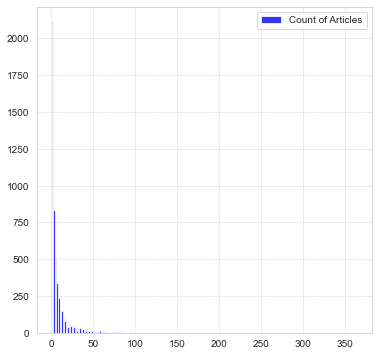

In [42]:
# plot histogram
plt.figure(figsize=(6,6))
plt.hist(df_ua_count['article_id'], alpha=0.8, label='Count of Articles', color = 'blue', bins=200)
plt.legend(loc='upper right')
plt.grid(color='black', alpha=0.2, linestyle = '--', linewidth = 0.5)
plt.show()

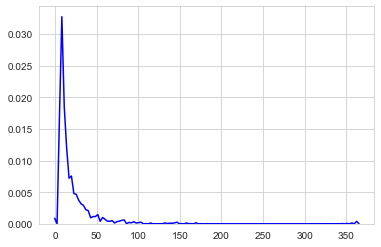

In [43]:
# plot density
sb.set_style('whitegrid')
sb.kdeplot(np.array(df_ua_count['article_id']), bw=0.5, color="blue")

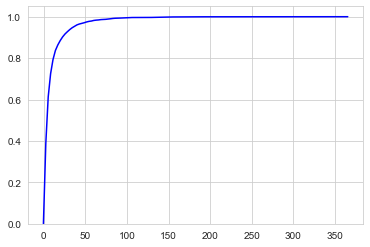

In [44]:
# plot cummulative function
sb.set_style('whitegrid')
sb.kdeplot(np.array(df_ua_count['article_id']), bw=0.5, cumulative=True, color='blue')

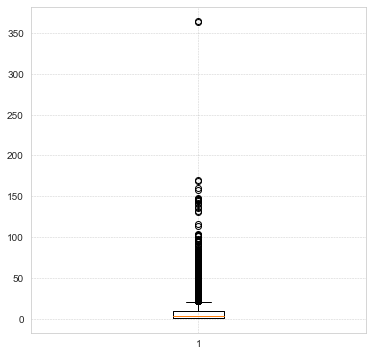

In [45]:
# plot boxplot
plt.figure(figsize=(6,6))
plt.boxplot(df_ua_count['article_id'])
plt.grid(color='black', alpha=0.2, linestyle = '--', linewidth = 0.5)
plt.show()

Descriptive statistics below will give us more exact values; however histogram, probability density function and boxplot show that most of the users have viewed somewhere between ~20 to 100 articles. There are some that have viewed 130-150 and only 2 users that have viewed more than 300 articles.

### Calculate different descriptive statistics for the Count of Articles by User

In [46]:
# Fill in the median and maximum number of user_article interactios below
median_val = df_ua_count['article_id'].median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df_ua_count['article_id'].max() # The maximum number of user-article interactions by any 1 user is ______.

# Calculate mode, mean and min
mode_val = df_ua_count['article_id'].mode()[0]
mean_val = df_ua_count['article_id'].mean()
min_val = df_ua_count['article_id'].min()

# Print all values
print('Mean is {}, mode is {}, median is {}, max is {} and min is {}'.format(mean_val, mode_val, median_val, max_views_by_user, min_val))

Mean is 8.930846930846931, mode is 1, median is 3.0, max is 364 and min is 1


In [47]:
# Standard deviation, Variance, Range
std_val = df_ua_count['article_id'].std()
var_val = std_val ** 2
range_val = max_views_by_user - min_val

# Print all values
print('Standard deviation is {}, variance is {} and range is {}'.format(std_val, var_val, range_val))

Standard deviation is 16.80226712655377, variance is 282.31618059206943 and range is 363


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [48]:
df_content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


In [49]:
df_content.shape

(1056, 5)

In [50]:
# Find and explore duplicate articles
df_content.shape[0] - df_content.drop_duplicates(['article_id']).shape[0]

5

In [51]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(['article_id'], keep='first')

In [52]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [53]:
len(df['article_id'].unique())

714

In [54]:
len(df_content['article_id'].unique())

1051

In [55]:
len(df.dropna()['email'].unique())

5148

In [56]:
df.shape[0]

45993

In [57]:
unique_articles = len(df['article_id'].unique()) # The number of unique articles that have at least one interaction
total_articles = len(df_content['article_id'].unique()) # The number of unique articles on the IBM platform
unique_users = len(df.dropna()['email'].unique()) # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [58]:
df_most_viewed = df[['article_id', 'email']].groupby('article_id').count().reset_index().sort_values('email', ascending=False)
df_most_viewed.head()

,article_id,email
699,1429.0,937
625,1330.0,927
701,1431.0,671
697,1427.0,643
652,1364.0,627


In [59]:
df_most_viewed.iloc[0][1]

937.0

In [60]:
str(df_most_viewed.iloc[0][0])

'1429.0'

In [61]:
most_viewed_article_id = str(df_most_viewed.iloc[0][0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df_most_viewed.iloc[0][1] # The most viewed article in the dataset was viewed how many times?

In [62]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [63]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [64]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df[['title', 'user_id']].groupby('title').count().reset_index()\
                        .sort_values('user_id', ascending=False).head(n)['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df[['article_id', 'user_id']].groupby('article_id').count().reset_index()\
                        .sort_values('user_id', ascending=False).head(n)['article_id'])
 
    return top_articles # Return the top article ids

In [65]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [66]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [142]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # remove duplcates from df so user_item matrix is correct
    # a user can see 1 article more than 1 time. This would distort user_item matirx/would be incorrect
    df = df.drop_duplicates(['article_id', 'user_id'], keep='first')    
    
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [143]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1).iloc[0] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [150]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = np.dot(user_item, np.transpose(user_item))

    # similarity for the given user
    similarity = similarity[:, user_id-1]
    
    # sort by similarity
    sorted_similarity = np.argsort(similarity)+1

    # create list of just the ids
    most_similar_users = list(sorted_similarity)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
    most_similar_users = most_similar_users[::-1]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [151]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [186]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    article_ids = user_item.iloc[user_id-1]
    article_ids = list(article_ids[article_ids != 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = df[df['article_id'].isin(article_ids)]['title'].unique()
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # get the list of similar users (already ordered based on similarity)
    similar_users = find_similar_users(user_id, user_item=user_item)
    print(similar_users)
    
    # get the list of articles the user has read already
    read_articles_id, read_articles_names = get_user_articles(user_id, user_item=user_item)
    
    # initiate list of recst
    recs = list()
    
    # loop through the similar users
    for x in similar_users:
        # get the ids and names of articles the user has seen
        article_ids, article_names = get_user_articles(x, user_item=user_item)
        
        article_ids = list(set(article_ids) - set(read_articles_id))
        article_names = df[df['article_id'].isin(article_ids)]['title']
        
        print(recs)
        print(article_ids)
        
        # append recommendations
        recs.extend(article_names)
        
        if len(recs) > m:
            break
            
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id    

In [187]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [188]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # compute similarity of each user to the provided user
    similarity = np.where(np.isnan(user_item), 0, user_item)
    similarity = np.dot(similarity, np.transpose(similarity))

    # similarity for the given user
    similarity = similarity[user_id-1]
    similarity = pd.DataFrame(similarity, columns = ['similarity']).reset_index()
    # index is my user_id -> need to increase it by 1
    similarity['index'] = similarity['index']+1
    
    # num interations
    num_interactions = df[['user_id', 'article_id']].groupby('user_id').count().reset_index()
    
    # join two datasets together
    neighbors_df = num_interactions.join(similarity, lsuffix='user_id', rsuffix='index')
    # drop extra user_id column
    neighbors_df.drop(['index'], axis=1, inplace=True)
    # drop the row assocaite with the user
    neighbors_df.drop(user_id-1, inplace=True)
    # rename column
    neighbors_df.rename(columns={"article_id": "num_interactions"}, inplace=True)
    # put similarity on second place
    neighbors_df.reindex(columns=['user_id', 'similarity', 'num_interactions'])
    # sort first by similairty and then num_interactions
    neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    # get the list of similar users (already ordered based on similarity)
    similar_users = get_top_sorted_users(user_id, df, user_item)
    
    # get the list of articles the user has read already
    read_articles_id, read_articles_names = get_user_articles(user_id, user_item=user_item)
    
    # initiate list of recst
    recs = list()
    recs_names = list()
    
    # loop through the similar users
    for x in similar_users['user_id']:
        # get the ids and names of articles the user has seen
        article_ids, article_names = get_user_articles(x, user_item=user_item)
        
        article_ids = list(set(article_ids) - set(read_articles_id))
        article_names = df[df['article_id'].isin(article_ids)]['title']
        
        # append recommendations
        recs.extend(article_ids)
        recs_names.extend(article_names)
        
        if len(recs) > m:
            break
            
    recs = recs[:m] 
    recs_names = recs_names[:m]
    
    return recs, recs_names

In [189]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1357.0', '302.0', '1444.0', '1157.0', '1160.0', '1391.0', '1426.0', '880.0', '1367.0', '125.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'ml optimization using cognitive assistant', 'ml optimization using cognitive assistant', 'ml optimization using cognitive assistant', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [190]:
# Find the user that is most similar to user 1 
get_top_sorted_users(1, df=df, user_item=user_item).iloc[0][0]

3933.0

In [191]:
# Find the 10th most similar user to user 131
get_top_sorted_users(131, df=df, user_item=user_item).iloc[9][0]

242.0

In [192]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).iloc[0][0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).iloc[9][0] # Find the 10th most similar user to user 131

In [193]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

*As it's a new user, we cannot make any recommendation based on similarity (the user has not read any articles so far). What we can do though is recommend the most popular articles. We can sort articles by the number of user interactions and pick the top ones.*

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [194]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# As mentioned earlier we will recommend top 10 articles based on how many users have viewed them
new_user_recs = df[['user_id', 'article_id']].groupby('article_id').count().sort_values('user_id', ascending=False)\
    .reset_index()['article_id'].tolist()[:10] # Your recommendations here

# Convert list elements to strings
new_user_recs = [str(x) for x in new_user_recs]

In [195]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [219]:
def make_content_recs(relevant_words, df=df, df_content=df_content, sort='count', seen_by=0):
    '''
    INPUT:
    1. relevant_words (list of strings): a list of words, can be of any length
    2. df_content (df): df_content from above workbook
    3. df (df): df from above workbook
    4. sort (str): default 'count'
    - 'count' -> df will be sorted based on the number of total appearances first
    - 'appearance' -> df will be sorted based on how many of the relevant_words appear in the article first
    5. seen_by (int): default 0
    -  specify how many users must have read the article in order to be relevant
    
    OUTPUT:
    Sorted dataframe with columns:
    1. article_id
    2. count_of_words
    - how many words from the list appear in title, doc_body, doc_description or doc_full_name of df_content
    - if words appears more than once, it is also more relevant for the user
    - count the total number of words from the list appearing in doc_body
    3. % of words that appeared at least once from the provided list
    4. how many other users interacted with the article -> information purpose only, does not affect the recommendation
    
    '''
    # if no list provided, end the function and print an error
    assert len(relevant_words) >= 1, 'You have to provide a list of at least 1 word as a string'
    
    articles = [int(x) for x in df_content['article_id'].unique()]
    articles.extend([int(x) for x in df['article_id'].unique()])
    articles = sorted(set(articles))
    count_words = 0
    count_appearance = 0
    count_input = len(relevant_words)
    
    # create new dataframe that has count of words for each article
    df_count_w = pd.DataFrame(columns=['article_id', 'count_of_words', 'fraction_of_words_appeared'])
    df_count_w['article_id'] = df_content['article_id']
    # join two datasets together
    num_interactions =  df[['user_id', 'article_id']].groupby('article_id').count().reset_index()
    df_count_w = pd.merge(df_count_w, num_interactions, on="article_id", how='left')
    df_count_w.rename(columns={'user_id': 'num_interactions'}, inplace=True)
    df_count_w['num_interactions'].fillna(0, inplace=True)

    # replace nan for df_content with '' so we don't get errors when we perform operations on strings
    df_content = df_content.fillna('')
    
    # replace nan for 'num_interactions' df_count_w for user_id with '' so we don't get errors when we perform operations on strings
    df_content = df_content.fillna('')    
    
    # loop through all of the articles
    for row in articles:
        # reset count words
        count_words = 0
        count_appearance = 0
        
        # create 1 string that combines doc_body, doc_description or doc_full_name
        string_to_check = ''
        try: string_to_check += df_content[df_content['article_id']==row]['doc_body'].iloc[0].lower() + ' '
        except: pass
        try: string_to_check += df_content[df_content['article_id']==row]['doc_description'].iloc[0].lower() + ' '
        except: pass
        try: string_to_check += df_content[df_content['article_id']==row]['doc_full_name'].iloc[0].lower() + ' '
        except: pass
        try: string_to_check += df[df['article_id']==row].iloc[0]['title'].lower()
        except:pass
        
        # check for each artcile how many times words from relevant_words input list appear in doc_body
        for nr, word in enumerate(relevant_words):
            count_words += string_to_check.lower().count(word)
            
            if word in string_to_check:
                count_appearance += 1
            
        df_count_w.at[row, 'count_of_words'] = count_words
        df_count_w.at[row, 'fraction_of_words_appeared'] = count_appearance / count_input
    
    # order the df_count_w based on the number of words that appeared
    if  sort == 'count':
        df_count_w.sort_values(['count_of_words', 'fraction_of_words_appeared'], ascending=False, inplace=True)
    elif sort == 'appearance':
        df_count_w.sort_values(['fraction_of_words_appeared', 'count_of_words'], ascending=False, inplace=True)
        
    # filter for articles that were seen by at least 'seen_by' number of users
    df_count_w = df_count_w[df_count_w['num_interactions']>=seen_by]
    
    df_count_w.reset_index(inplace=True)    
    df_count_w.drop(['index'], axis=1, inplace=True)    
    
    return df_count_w

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### Explanation how **make_content_recs** works:
1. **make_content_recs** function will provide top recommended articles based on user input
2. user specifies:
    - a list of words (e.g. ['data', 'ibm', 'energy'])
    - how recommendations should be defined / df sorted
    - how many users must have seen the article for it to be relevant for recommendation
3. function will return a data frame that shows
    - how many times all these words appeared in an article
    - how many of the given words appeared at least once
    - how many interactions other users had with this article
4. user can sort the output either based on the total count or appearance

### Novelity?
There is some aspect of novelity in **make_content_recs** function. When function checks for whether words are in a text, it doesn't look for exact words but it can be any form of that word. If you search for *water* you would also cover words such as *waterfall*. <br><br>
We are not checking for actual context of the words, which offers both some degree of novelity as well as place for potential improvement. You might be searching for *energy* because you are interested in articles related to *energy* consumption of different countries. But you would also get recommended articles that contain *energy drinks* for example. We could solve the latter by leveraging the work we've done on the *Disaster Response* project where we trained a model to clasify tweets baseed on provided words.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [221]:
# make recommendations for a brand new user
# Assumptions: user is interested in topics of technology, research, data and program. 
# At leat 10 other people must have read the article
# All words must be present in the artcile
new_df = make_content_recs(['technology', 'research', 'data', 'program'], sort='appearance', seen_by=10)
new_df = new_df[new_df['fraction_of_words_appeared']==1]

print('Our brand new user should read these articles: {}'.format(new_df.article_id.unique()))
print('And this is the overall df:')
new_df

Our brand new user should read these articles: [ 569. 1006.  162.  618.  723.  230.  390.  656.  113.  524.    2.  310.
  383.  151.  336.  881.  500. 1018.  952.  195.  715.]
And this is the overall df:


,article_id,count_of_words,fraction_of_words_appeared,num_interactions
0,569.0,117,1,18.0
1,1006.0,105,1,14.0
2,162.0,64,1,150.0
3,618.0,60,1,20.0
4,723.0,60,1,95.0
5,230.0,58,1,33.0
6,390.0,52,1,270.0
7,656.0,50,1,19.0
8,113.0,47,1,28.0
9,524.0,47,1,22.0


In [222]:
# make a recommendations for a user who only has interacted with article id '1427.0'
# Let's look at article 1427 and count the most common words in this artcile. 
df[df['article_id']==1427].iloc[0].title
# given we have data for it only in df dataset, let use all the available words
list_1427 = df[df['article_id']==1427].loc[42].title.split(' ')
# title has '&' which we are not interested in
list_1427.remove('&')
# now we will use list_1427 for predictions
new_df = make_content_recs(list_1427, sort='appearance', seen_by=10)
# Let's assume he wants at least half of the words to be mentioned and wants to read top 10 articles
new_df = new_df[new_df['fraction_of_words_appeared']==0.5][:10]

print('User who wants recommendation based on article 1427 should read these articles: {}'.format(new_df.article_id.unique()))
print('And this is the overall df:')
new_df

User who wants recommendation based on article 1427 should read these articles: [  30. 1000. 1048.  124.   51.  500.  260.  721.  164.   74.]
And this is the overall df:


,article_id,count_of_words,fraction_of_words_appeared,num_interactions
83,30.0,98,0.5,17.0
84,1000.0,92,0.5,16.0
85,1048.0,92,0.5,108.0
86,124.0,88,0.5,325.0
87,51.0,86,0.5,124.0
88,500.0,86,0.5,12.0
89,260.0,76,0.5,222.0
90,721.0,75,0.5,31.0
91,164.0,71,0.5,222.0
92,74.0,69,0.5,69.0


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [224]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [225]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [226]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**
<br>
In the lesson we had nan values and SVD cannot work on missing values. Here we have only 1s and 0s so SVD can be performed

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

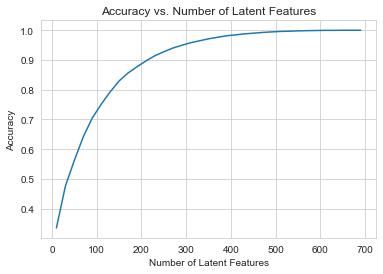

In [227]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [228]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item_train = np.where(np.isnan(user_item_train), 0, user_item_train)
    
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item_test = np.where(np.isnan(user_item_test), 0, user_item_test)
    
    test_idx = df_train.user_id.unique()
    test_arts = df_train.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [229]:
# overlap of train and test set users -> for these we can make prediction
len(list(set(df_train.user_id.unique()) & set (df_test.user_id.unique())))

20

In [230]:
# nr of users for which we cant make predictions for
len(df_test.user_id.unique())-len(list(set(df_train.user_id.unique()) & set (df_test.user_id.unique())))

662

In [231]:
# overlap of train and test set articles -> for these we can make prediction
len(list(set(df_train.article_id.unique()) & set (df_test.article_id.unique())))

574

In [232]:
# nr of articles for which we cant make predictions for
len(df_test.article_id.unique()) - len(list(set(df_train.article_id.unique()) & set (df_test.article_id.unique())))

0

# COMMENT:
<br>
There is a mistake / typo in the t.sol_4_test function where it assumes for 3rd and 4th dictionary entries to refer to "movies" as opposed to "articles". In order to not make changes to the function itself, I amended sol_4_dict.
<br>

![title](error_soL_4_dict.png)

In [233]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [234]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [235]:
# articles available in test and train set
articles_train = list(df_train.article_id.unique())
articles_train_df = pd.DataFrame(articles_train)
articles_train_df.columns = ['article_id']
articles_train_idx = articles_train_df[articles_train_df.article_id.isin(list(df_test.article_id.unique()))].index

articles_test = list(df_test.article_id.unique())
articles_test_df = pd.DataFrame(articles_test)
articles_test_df.columns = ['article_id']
articles_test_idx = articles_test_df[articles_test_df.article_id.isin(list(df_train.article_id.unique()))].index

# users available in test and train set
users_train = list(df_train.sort_values('user_id').user_id.unique())
users_train_df = pd.DataFrame(users_train)
users_train_df.columns = ['user_id']
users_train_df.reset_index(inplace=True)
users_train_idx = users_train_df[users_train_df.user_id.isin(list(df_test.user_id.unique()))].index

users_test = list(df_test.sort_values('user_id').user_id.unique())
users_test_df = pd.DataFrame(users_test)
users_test_df.columns = ['user_id']
users_test_df.reset_index(inplace=True, drop=True)
users_test_idx = users_test_df[users_test_df.user_id.isin(list(df_train.user_id.unique()))].index

In [236]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+10,10)
sum_errs_test = list()
sum_errs_train = list()
sum_errs_total = list()

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # TRAIN DATA
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est)   
    
    # train errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))    
    sum_errs_train.append(err_train)
    
    # TEST DATA
    # restrict to available users and articles, i.e. account for cold start problem
    user_item_est = user_item_est[users_train_idx]
    user_item_est = user_item_est[:, articles_train_idx]

    # restrict user_item_test to the same users and articles
    user_item_test_k = user_item_test[users_test_idx]
    user_item_test_k = user_item_test_k[:, articles_test_idx]        
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_test_k, user_item_est)
    
    # test errors and keep track of them
    err_test = np.sum(np.sum(np.abs(diffs_test)))    
    sum_errs_test.append(err_test)     

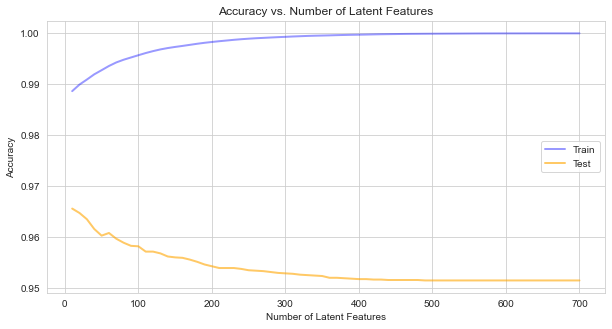

In [237]:
# Plot
plt.figure(figsize=(10,5));
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), \
         color='blue', alpha = 0.4, label='Train', linewidth=2);
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(20*user_item_test.shape[1]),\
         color='orange', alpha = 0.6, label='Test', linewidth=2);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc='center right');
plt.rcParams.update({'font.size': 15});

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

*A common problem in machine learnine is overfitting, i.e. the process where prediction funciton it trained to fit only a limited set of observations. The result is that it might seem like our model has a very good prediction rate / accuracy when in fact it has a poor one.*

*This is likely to be the problem in our case as well. We've seen before that the number of articles that the users interact with is mainly in the range of 20-100 (and even less than 100 in most cases). As we increase the number of latent features we end up with a data that is more "scarce"; the distribution of 1s and 0s (whether someone has read the artcile) is more "scarce". This casues our model to overfit. We can also see that based on the accuracy curves plots:*
 - *accuracy on the train data increases as we add more latent features*
 - *however the accuracy on the test data decreases as we add more latent features*

*Therefore we should rather use less latent features, e.g. between 20-100 in order to not overfit the model too much.*

*In order to have reliable results based on SVD approach, we would require considerably more data and also a better overlap for users between train and test data. At this stage it would be better to not use SVD at all and instead offer recommendations to users based on collaborative filtering, content based or rank based approach.*